In [1]:
import io
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim
from collections import Counter
import pickle as pkl
import string
import random
import pdb
import nltk
from nltk import ngrams
from collections import Counter
from collections import defaultdict

import copy


import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

import time
import math

In [2]:
torch.set_default_tensor_type('torch.DoubleTensor')

In [3]:
random.seed(152)

nowPath = os.path.abspath('.')
dataPath = nowPath + '//dataSourceCsv'
resPath = nowPath + '//resultsRNN'
resSeq2Seq = nowPath + '//resultsS2S'

all_train = []
all_val = []

In [4]:
def showPlot(points, title):
    fig, ax = plt.subplots()
    lines = {}
    lines['cur'], = ax.plot(range(len(points)), points, label='train loss')
    ax.set_title(title)

In [5]:
def pkl_dumper(objct, file_name):
    with open(file_name, 'wb+') as f:
        pkl.dump(objct, f, protocol=None)

def pkl_loader(file_name):
    with open(file_name, 'rb') as f:
        objct = pkl.load(f, encoding = 'bytes')
    return(objct)

In [6]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [7]:
allColNames = pkl_loader(dataPath + '//allColNames.p')
colHeader, colSlot = allColNames['columnHeaders'], allColNames['columnSlots']
allTrainTS = pkl_loader(dataPath + '//allTrainTS.p')
allIDs = pkl_loader(dataPath + '//allIDs.p')
allTgts = pkl_loader(dataPath + '//allTgts.p')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
newIndex = [i for i, item in enumerate(allTrainTS) if sum(sum(item[:, :9])) != 0.0]
allTgts = np.array(allTgts)
allTrainTS = np.array(allTrainTS)
allTgts = allTgts[newIndex, 3]
allTrainTS = allTrainTS[newIndex]
allIDs = np.array(allIDs)
allIDs = allIDs[newIndex]

In [32]:
allTrainTS[3][14:, [1,4]]

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [33]:
allPairs = [[item[:9, :], item[9:, [7, 16]]] for item in allTrainTS.transpose(0, 2, 1)]

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layer):
        super(EncoderRNN, self).__init__()
        self.num_layer = num_layer
        self.hidden_size = hidden_size
        self.linear = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layer)

    def forward(self, input, hidden):
        # print('InType:', input.type())
        output = self.linear(input).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layer, 1, self.hidden_size, device=device)

In [12]:
class Attn(nn.Module):
    def __init__(self, hidden_size, method='concat'):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)

    def forward(self, hidden, encoder_outputs):
        '''
        :param hidden: 
            previous hidden state of the decoder, in shape (layers*directions,B,H)
        :param encoder_outputs:
            encoder outputs from Encoder, in shape (T,B,H)
        :return
            attention energies in shape (B,T)
        '''
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)
        H = hidden.repeat(max_len,1,1).transpose(0,1)
        encoder_outputs = encoder_outputs.transpose(0,1) # [B*T*H]
        attn_energies = self.score(H,encoder_outputs) # compute attention score
        return F.softmax(attn_energies, 2) # normalize with softmax

    def score(self, hidden, encoder_outputs):
        #print('hl size:{}, eo size:{}'.format(hidden.size(), encoder_outputs.size()))
        energy = F.tanh(self.attn(torch.cat([hidden, encoder_outputs.transpose(0,1).unsqueeze(0)], 2))) # [B*T*2H]->[B*T*H]
        energy = energy.transpose(2,1) # [B*H*T]
        v = self.v.repeat(energy.size()[0],1).unsqueeze(0) #[1*B*H]
        #print('v size:{}, eng size:{}'.format(v.size(), energy.size()))
        energy = torch.bmm(v,energy) # [B*1*T]
        #return energy.squeeze(1) #[B*T]
        return energy

In [14]:
class BahdanauAttnDecoderRNN_NoSM(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_len = 100):
        super(BahdanauAttnDecoderRNN_NoSM, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_len = max_len
        
        # Define layers
        self.linear = nn.Linear(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        # self.attn = nn.Linear(hidden_size, self.max_len)
        self.attn = Attn(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, cur_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step, but will use all encoder outputs
        
        # Get the embedding of the current input word (last output word)
        # print('ci size:{}'.format(cur_input.size()))
        vec_input = self.linear(cur_input).view(1, 1, -1) # S=1 x B x N
        vec_input = self.dropout(vec_input)
        # print('vi size:{}, lh size:{}, enc_out size:{}'.format(vec_input.size(), last_hidden.size(), encoder_outputs.size()))
        attn_weights = self.attn(last_hidden[-1], encoder_outputs )
        #print('wt size:{}, eo size:{}'.format(attn_weights.size(), encoder_outputs.size()))
        attn_applied = attn_weights.bmm(encoder_outputs.unsqueeze(0))  # (B,1,V)
        attn_applied = attn_applied.transpose(0, 1)
        #print('we size:{}, lh size:{}, aa size:{}'.format(word_embedded.size(), last_hidden.size(), attn_applied.size()))
        rnn_input = torch.cat((vec_input, attn_applied), 2)
        
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = self.out(output)
        #print(output.size())
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

In [45]:
teacher_forcing_ratio = 0.5

def train_NoSM(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # print("inLen:{},tgtLen:{}".format(input_length, target_length))

    encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)
    # print('encOutSize:{}'.format(encoder_outputs.size()))

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # decoder_input = torch.tensor([[0.0]*len(colHeader)], device=device)
    decoder_input = input_tensor[input_length-1][[7, 16]]
    # print(decoder_input.size())

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    # use_teacher_forcing = False
    # print(target_tensor.size())

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # print("typeOrg:{}, typeChanged:{}".format(target_tensor[di].type(), target_tensor[di].unsqueeze(0).type()))
            # print("typeDcd:{}".format(decoder_output.type()))
            # print(decoder_output)
            # print(target_tensor[di].unsqueeze(0))
            loss += criterion(decoder_output.double(), target_tensor[di].unsqueeze(0).double())
            decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            # print('forced', decoder_input)

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # topv, topi = decoder_output.topk(1)
            # decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = decoder_output
            # print("typeOrg:{}, typeChanged:{}".format(target_tensor[di].type(), target_tensor[di].unsqueeze(0).type()))
            # print("typeDcd:{}".format(decoder_output.type()))
            # print(decoder_output)
            # print(target_tensor[di].unsqueeze(0))
            loss += criterion(decoder_output.double(), target_tensor[di].unsqueeze(0).double())
            # print('Noforced', decoder_input)
            # print('Noforced_dout', decoder_output)
            

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [46]:
def trainIters_NoSM(encoder, decoder, n_iters, pairs, n_epoches=1, print_every=1000, plot_every=1000, learning_rate=1e-3, \
                    criterion = nn.KLDivLoss(), marker='NoSM', lr_decrease = True):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    trainPairs = copy.deepcopy(pairs)
    random.shuffle(trainPairs)
    # training_pairs = [tensorsFromPair(random.choice(pairs))
    #                   for i in range(n_iters)]
    training_pairs = [[torch.tensor(pair[0], dtype=torch.double, device=device), \
                       torch.tensor(pair[1], dtype=torch.double, device=device)] for pair in trainPairs] * n_epoches
    # criterion = nn.NLLLoss().double()
    # criterion = nn.KLDivLoss()
    criterion = criterion
    if n_epoches > 1:
        n_iters = len(training_pairs)

    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_NoSM(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    pkl_dumper(plot_losses, resSeq2Seq + '//trainS2S1120'+str(hidden_size)+'_'+str(n_layers)+marker+'.p')
    showPlot(plot_losses, 'Train loss with MSE Loss')
    

In [61]:
def predictor(input_tensor, target_tensor, encoder, decoder, criterion):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # print(input_length, target_length)

    encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)
    # print('encOutSize:{}'.format(encoder_outputs.size()))

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        # print(encoder_output[0, 0])

    # decoder_input = torch.tensor([[0.0]*len(colHeader)], device=device)
    decoder_input = input_tensor[input_length-1][[7, 16]]

    decoder_hidden = encoder_hidden
    decoder_outputs = torch.zeros(target_length, out_size , device=device)

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_input = decoder_output
        # print(decoder_outputs.size(), decoder_output.size())
        decoder_outputs[di] = decoder_output[0]
        
        loss += criterion(decoder_output.double(), target_tensor[di].unsqueeze(0).double())

    return (decoder_outputs, target_tensor, loss.item() / target_length)

0m 14s (- 17m 51s) (200 1%) 4233.8596
0m 29s (- 17m 31s) (400 2%) 4269.4832
0m 43s (- 17m 16s) (600 4%) 4814.9873
0m 58s (- 17m 2s) (800 5%) 4221.6948
1m 12s (- 16m 46s) (1000 6%) 4126.2439
1m 27s (- 16m 32s) (1200 8%) 4128.5523
1m 42s (- 16m 17s) (1400 9%) 4120.4084
1m 56s (- 16m 2s) (1600 10%) 4808.9613
2m 11s (- 15m 47s) (1800 12%) 4380.5148
2m 25s (- 15m 33s) (2000 13%) 3965.2284
2m 40s (- 15m 19s) (2200 14%) 3736.9513
2m 55s (- 15m 4s) (2400 16%) 3818.4472
3m 9s (- 14m 50s) (2600 17%) 3976.7798
3m 24s (- 14m 36s) (2800 18%) 3518.5640
3m 39s (- 14m 22s) (3000 20%) 3584.7458
3m 53s (- 14m 8s) (3200 21%) 3221.0633
4m 8s (- 13m 53s) (3400 22%) 3119.4493
4m 23s (- 13m 39s) (3600 24%) 3101.3900
4m 37s (- 13m 24s) (3800 25%) 2953.1989
4m 52s (- 13m 10s) (4000 27%) 3324.6860
5m 7s (- 12m 55s) (4200 28%) 2603.6778
5m 21s (- 12m 41s) (4400 29%) 2517.0097
5m 36s (- 12m 26s) (4600 31%) 4584.9609
5m 51s (- 12m 12s) (4800 32%) 2335.2585
6m 5s (- 11m 57s) (5000 33%) 2164.6059
6m 20s (- 11m 42s) 

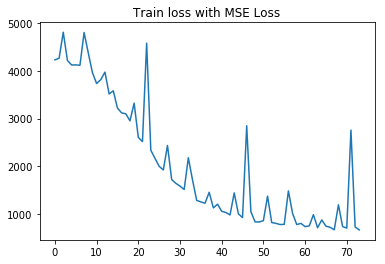

In [51]:
###TrainCuda
hidden_size = 200
in_size = len(colHeader)
out_size = 2
n_layers = 3
encoder3 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
attn_decoder3 = BahdanauAttnDecoderRNN_NoSM(hidden_size, out_size, n_layers=n_layers, dropout_p=0.1).to(device)

trainIters_NoSM(encoder3, attn_decoder3, 1, allPairs, n_epoches = 3, print_every=200, plot_every = 200, learning_rate=2e-7, criterion = nn.MSELoss())

In [54]:
torch.save(encoder3.state_dict(), resSeq2Seq + "//encoder_test1125_"+str(hidden_size)+"_"+str(n_layers)+'NoSM'+".pth")
torch.save(attn_decoder3.state_dict(), resSeq2Seq + "//attn_decoder_test1125_"+str(hidden_size)+"_"+str(n_layers)+'NoSM'+".pth")

In [ ]:
trainPltNoSM = pkl_loader(resSeq2Seq+'//trainS2S1125200_3NoSM.p')
showPlot(trainPltNoSM, 'Train loss with KLD Loss')

In [55]:
def plotter(c1, c1pred, c2, c2pred, c3, c3pred, ind, title, label, lim):
    listXlabel = colSlot[-6:]
    c1 = np.array(c1.detach().numpy())[:,ind]
    c2 = np.array(c2.detach().numpy())[:,ind]
    c3 = np.array(c3.detach().numpy())[:,ind]
    c1pred = np.array(c1pred.detach().numpy())[:,ind]
    c2pred = np.array(c2pred.detach().numpy())[:,ind]
    c3pred = np.array(c3pred.detach().numpy())[:,ind]
    fig, ax = plt.subplots(figsize=(12, 8))
    lines = {}
    lines['c1'], = ax.plot(listXlabel, c1, '-', label='c1_true, obesity', color = 'red')
    lines['c1pred'], = ax.plot(listXlabel, c1pred, '--', label='c1_pred, obesity', color = 'red')
    lines['c2'], = ax.plot(listXlabel, c2, '-', label='c2_true, non-obesity', color = 'blue')
    lines['c2pred'], = ax.plot(listXlabel, c2pred, '--', label='c2_pred, non-obesity', color = 'blue')
    lines['c3'], = ax.plot(listXlabel, c3, '-', label='c3_true, non-obesity', color = 'green')
    lines['c3pred'], = ax.plot(listXlabel, c3pred, '--', label='c3_pred, non-obesity', color = 'green')
    legend = ax.legend(loc='lower right', shadow=True)
    ax.set_ylabel(label)
    # ax.set_xlabel(listXlabel)
    ax.set_title(title)
    plt.ylim(lim[0], lim[1])

In [57]:
predPairs = [[torch.tensor(pair[0], dtype=torch.double, device=device), \
               torch.tensor(pair[1], dtype=torch.double, device=device)] for pair in allPairs]


In [62]:
preds = [0]*3
tgts = [0]*3
listChild = [9, 16, 512]
for j, i in enumerate(listChild):
    preds[j], tgts[j], loss = predictor(predPairs[i][0], predPairs[i][1], encoder3, attn_decoder3, nn.KLDivLoss())

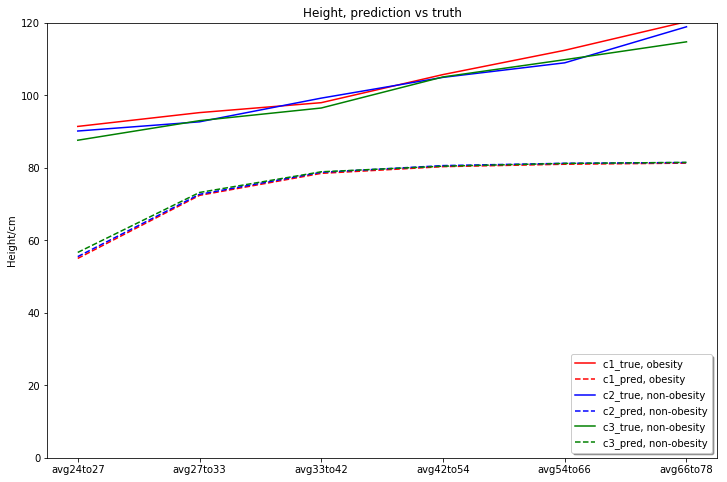

In [66]:
plotter(tgts[0], preds[0], tgts[1], preds[1], tgts[2], preds[2], 0, 'Height, prediction vs truth', 'Height/cm', [0, 120])

0m 15s (- 18m 38s) (200 1%) 848.6343
0m 30s (- 18m 16s) (400 2%) 765.3151
0m 45s (- 18m 4s) (600 4%) 755.0453
1m 1s (- 17m 48s) (800 5%) 695.0918
1m 16s (- 17m 31s) (1000 6%) 674.0856
1m 31s (- 17m 17s) (1200 8%) 1702.0918
1m 46s (- 17m 0s) (1400 9%) 677.5228
2m 1s (- 16m 45s) (1600 10%) 725.2653
2m 17s (- 16m 29s) (1800 12%) 856.8482
2m 32s (- 16m 14s) (2000 13%) 675.3181
2m 47s (- 15m 59s) (2200 14%) 651.0569
3m 2s (- 15m 43s) (2400 16%) 720.7781
3m 17s (- 15m 28s) (2600 17%) 802.5384
3m 32s (- 15m 13s) (2800 18%) 686.2893
3m 48s (- 14m 58s) (3000 20%) 2613.4014
4m 3s (- 14m 42s) (3200 21%) 675.7389
4m 18s (- 14m 27s) (3400 22%) 639.9671
4m 33s (- 14m 12s) (3600 24%) 1103.2700
4m 49s (- 13m 57s) (3800 25%) 705.8449
5m 4s (- 13m 41s) (4000 27%) 675.8871
5m 19s (- 13m 26s) (4200 28%) 663.2960
5m 34s (- 13m 11s) (4400 29%) 886.9848
5m 49s (- 12m 55s) (4600 31%) 1161.7097
6m 4s (- 12m 40s) (4800 32%) 698.4295
6m 20s (- 12m 25s) (5000 33%) 821.3938
6m 35s (- 12m 9s) (5200 35%) 734.4794
6m

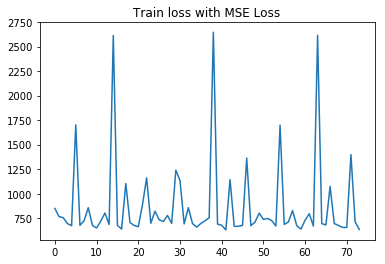

In [68]:
###TrainCuda
hidden_size = 200
in_size = len(colHeader)
out_size = 2
n_layers = 3
encoder4 = copy.deepcopy(encoder3)
attn_decoder4 = copy.deepcopy(attn_decoder3)

trainIters_NoSM(encoder4, attn_decoder4, 1, allPairs, n_epoches = 3, print_every=200, plot_every = 200, learning_rate=1e-8, criterion = nn.MSELoss())

In [69]:
torch.save(encoder4.state_dict(), resSeq2Seq + "//encoder_test1125_"+str(hidden_size)+"_"+str(n_layers)+'NoSM_MSERetrain'+".pth")
torch.save(attn_decoder4.state_dict(), resSeq2Seq + "//attn_decoder_test1125_"+str(hidden_size)+"_"+str(n_layers)+'NoSM_MSERetrain'+".pth")